In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import torch

In [2]:
n = 30 # num of series 
T = 20000 # len of series

In [3]:
data = np.zeros((n,T))
data_params = np.zeros((n,3))
for series in range(n):
    t0 = np.random.randint(50,101)
    w = np.random.randint(40,51) 
    scale = 0.3
    ran_seed = np.random.randint(0,2)
    tfun = np.sin if ran_seed else np.cos
    data_params[series] = np.array([t0, w, ran_seed])
    for t in range(T):
        bias = np.random.randn()
        data[series, t] = tfun((t -t0)/w) + scale*bias

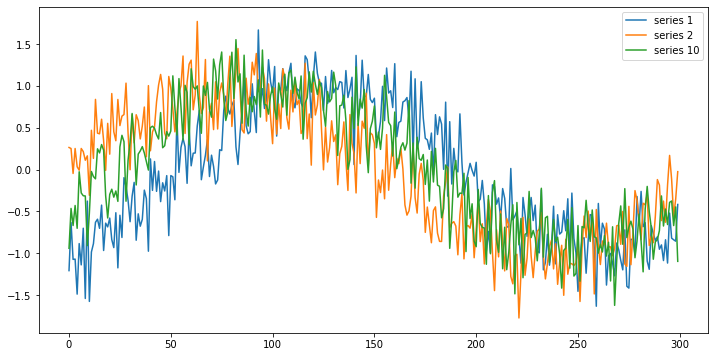

In [4]:
plt.figure(figsize=(12,6))
plt.plot(data[0, :300], label='series 1')
plt.plot(data[1, :300], label='series 2')
plt.plot(data[9, :300], label='series 10')
plt.legend()

In [9]:
errors_num = 5
errors = []
for i in range(errors_num):
    t0 = np.random.randint(50,101)
    w = np.random.randint(40,51) 
    scale = 0.3
    ran_seed = np.random.randint(0,2)
    tfun = np.sin if ran_seed else np.cos
    len_of_er = np.random.randint(30,91)
    
    err = []
    for t in range(len_of_er):
        bias = np.random.randn()
        err.append(tfun((t -t0)/w) + scale*bias)

    errors.append(err)

errors = np.array(errors, dtype=object)

In [10]:
n_er_inos = 3
ser_w_er = []
er_start = np.zeros(errors_num, dtype=int)
er_end = np.zeros(errors_num, dtype=int)
data_w_er = np.copy(data)

for i, error in enumerate(errors):
    er_start[i] = np.random.randint(10001, T-90)
    er_end[i] = er_start[i] + len(error)

er_sort_ind = np.argsort(er_start)
er_start = er_start[er_sort_ind]
er_end = er_end[er_sort_ind]
errors = errors[er_sort_ind]

for er_i in range(n_er_inos):
    ser_num = np.random.randint(0,n)
    while ser_num in ser_w_er:
        ser_num = np.random.randint(0,n)
    ser_w_er.append(ser_num)

er_pos = dict()
# for j in range(errors_num):
#     cur_ts = ser_w_er[np.random.randint(0, n_er_inos)]
#     if cur_ts in er_pos:
#         er_pos[cur_ts].append([er_start[j], er_end[j]])
#     else:
#         er_pos[cur_ts] = [[er_start[j], er_end[j]]]
#     data_w_er[cur_ts, er_start[j]:er_end[j]] = errors[j]

In [11]:
for it in errors:
    print(len(it))

49
62
66
87
65


In [12]:
er_pos = dict()

data_w_er[ser_w_er[0], er_start[0]:er_end[0]] = errors[0]

data_w_er[ser_w_er[0], er_start[1]:er_end[1]] = errors[1]
data_w_er[ser_w_er[1], er_start[1]:er_end[1]] = errors[1]

data_w_er[ser_w_er[0], er_start[2]:er_end[2]] = errors[2]
data_w_er[ser_w_er[1], er_start[2]:er_end[2]] = errors[2]
data_w_er[ser_w_er[2], er_start[2]:er_end[2]] = errors[2]

shift1 = 60
data_w_er[ser_w_er[1], er_start[3]:er_end[3]] = errors[3]
data_w_er[ser_w_er[2], er_start[3]+shift1:er_end[3]+shift1] = errors[3]

shift2 = 120
data_w_er[ser_w_er[0], er_start[4]+shift2:er_end[4]+shift2] = errors[4]
data_w_er[ser_w_er[1], er_start[4]:er_end[4]] = errors[4]

er_pos[ser_w_er[0]] = [ [er_start[0], er_end[0]], 
                        [er_start[1] ,er_end[1]], 
                        [er_start[2], er_end[2]],
                        [er_start[4]+shift2, er_end[4]+shift2]  ]
        
er_pos[ser_w_er[1]] = [ [er_start[1],er_end[1]],
                        [er_start[2],er_end[2]],
                        [er_start[3],er_end[3]],
                        [er_start[4], er_end[4]] ]          

er_pos[ser_w_er[2]] = [ [er_start[2], er_end[2]],
                        [er_start[3]+shift1, er_end[3]+shift1]  ]

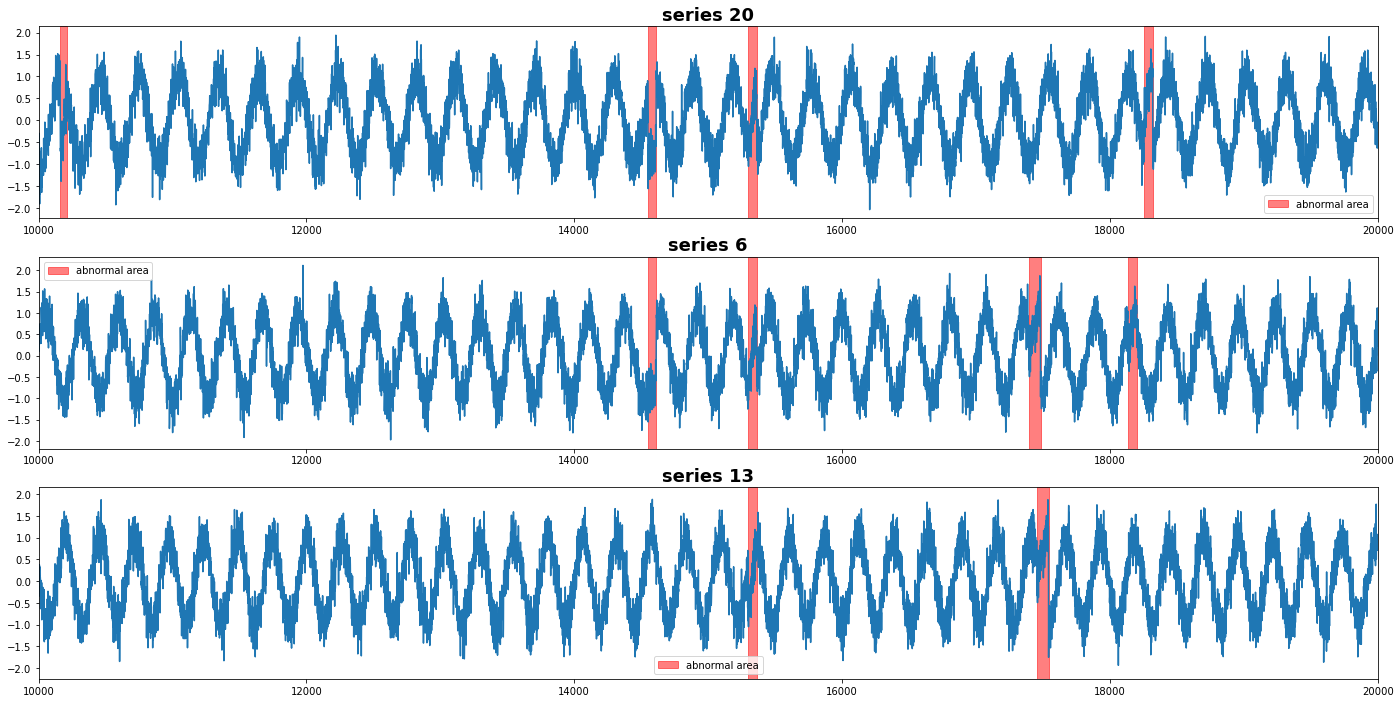

In [13]:
fig = plt.figure(figsize=(24,12))

# test_np_ct = test_np[:, :99*STRIDE+WIN_SIZE]
test_np_ct = data_w_er
test_sec_size = test_np_ct.shape[1]

params = {  'color':'red',
            'alpha':0.5 }

for i, ser in enumerate(er_pos):
    ax = fig.add_subplot(311+i)
    ax.plot(test_np_ct[ser])
    ax.set_title('series {}'.format(ser), weight='bold', size=18)

    is_first = True
    for er_start, er_end in er_pos[ser]:
        if is_first:
            ax.axvspan(er_start, er_end, label='abnormal area', **params)
            is_first=False
        else: 
            ax.axvspan(er_start, er_end, **params)

    ax.legend()
    ax.set_xlim([10000, 20000])


In [14]:
full_data = torch.FloatTensor(data_w_er)

In [15]:
full_data.shape

torch.Size([30, 20000])

In [16]:
train = full_data[:, :8001]
valid = full_data[:, 8001:10001]
test = full_data[:, 10001:]

In [17]:
len(train[:,0])

30

In [18]:
PATH = 'shift_sim_test'
with open('../data/{}/train.pkl'.format(PATH), 'wb') as f:
    pickle.dump(train, f)
with open('../data/{}/valid.pkl'.format(PATH), 'wb') as f:
    pickle.dump(valid, f)
with open('../data/{}/test.pkl'.format(PATH), 'wb') as f:
    pickle.dump(test, f) 

In [19]:
for ser in er_pos:
    for i in range(len(er_pos[ser])):
        for j in range(len(er_pos[ser][i])):
            er_pos[ser][i][j] -= train.shape[1] + valid.shape[1]
    # er_pos[ser] -= train.shape[1] + valid.shape[1]
    print(er_pos[ser]) 

[[161, 210], [4549, 4611], [5296, 5362], [8254, 8319]]
[[4549, 4611], [5296, 5362], [7394, 7481], [8134, 8199]]
[[5296, 5362], [7454, 7541]]


In [32]:
with open('../data/{}/errors_positions.pkl'.format(PATH), 'wb') as f:
    pickle.dump(er_pos, f)